In [1]:
import json
import random

import numpy as np
from pysidt import Datum, MultiEvalSubgraphIsomorphicDecisionTree
from pysidt.decomposition import atom_decomposition_noH
from pysidt.plotting import plot_tree

from molecule.molecule import Group, Molecule, ATOMTYPES

In [2]:
with open("../data/rmgdbH298CHOstablenoringnoads.json", "r") as f:
    data = json.load(f)

In [3]:
training_data = []
for i, x in enumerate(data):
    d = Datum(Molecule().from_adjacency_list(x[0], check_consistency=True), x[1])
    dup = False
    for td in training_data:
        if td.mol.is_isomorphic(d.mol):
            dup = True
            break
    if not dup:
        training_data.append(d)

In [4]:
random.shuffle(training_data)
len(training_data)

184

In [5]:
train = training_data[:150]
test = []
test = training_data[150:]

In [6]:
root = Group().from_adjacency_list("""1 * R u0 px cx""")

sidt = MultiEvalSubgraphIsomorphicDecisionTree(
    atom_decomposition_noH,
    root_group=root,
    r=[ATOMTYPES[x] for x in ["C", "O"]],
    r_bonds=[1, 2, 3, 1.5],
    r_un=[0],
    fract_nodes_expand_per_iter=0.1,
)

In [7]:
sidt.generate_tree(data=train, validation_set=test, max_nodes=4)

INFO:root:training MAE: 122033.79567150374
INFO:root:validation MAE: 170164.84233856888
INFO:root:# nodes: 1
/home/gridsan/hwpang/mambaforge/envs/pysidt_env_20240508/lib/python3.9/site-packages/scipy/sparse/_index.py:108: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/home/gridsan/hwpang/Projects/pysidt_dev/PySIDT/pysidt/sidt.py:648: RuntimeWarning: divide by zero encountered in scalar divide
  dy = self.data_delta[i] / len(self.mol_node_maps[datum]["mols"])
INFO:root:training MAE: 95598.38756692603
INFO:root:validation MAE: 109468.65495147534
INFO:root:# nodes: 3


adding node Root_1R->C


/home/gridsan/hwpang/mambaforge/envs/pysidt_env_20240508/lib/python3.9/site-packages/scipy/sparse/_index.py:108: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/home/gridsan/hwpang/Projects/pysidt_dev/PySIDT/pysidt/sidt.py:648: RuntimeWarning: divide by zero encountered in scalar divide
  dy = self.data_delta[i] / len(self.mol_node_maps[datum]["mols"])
INFO:root:training MAE: 95683.43983478994
INFO:root:validation MAE: 109595.96516534565
INFO:root:# nodes: 4
/home/gridsan/hwpang/mambaforge/envs/pysidt_env_20240508/lib/python3.9/site-packages/scipy/sparse/_index.py:108: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


adding node Root_N-1R->C_Ext-1O-R


/home/gridsan/hwpang/Projects/pysidt_dev/PySIDT/pysidt/sidt.py:648: RuntimeWarning: divide by zero encountered in scalar divide
  dy = self.data_delta[i] / len(self.mol_node_maps[datum]["mols"])
INFO:root:training MAE: 84975.61140214758
INFO:root:validation MAE: 93454.05845995247
INFO:root:# nodes: 6
/home/gridsan/hwpang/mambaforge/envs/pysidt_env_20240508/lib/python3.9/site-packages/scipy/sparse/_index.py:108: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


adding node Root_N-1R->C_Ext-1O-R_2C->O


INFO:root:Postpruning based on best validation error
INFO:root:training MAE: 84975.61137610373
INFO:root:validation MAE: 93454.05823551906
INFO:root:# nodes: 6
/home/gridsan/hwpang/mambaforge/envs/pysidt_env_20240508/lib/python3.9/site-packages/scipy/sparse/_index.py:108: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


In [8]:
sidt.regularize(data=train, check_data=True)

In [9]:
sidt.nodes

{'Root': Root rule: -29147.929370944297 +|- 127605651.39610648 (N=795.0) depth: 0,
 'Root_1R->C': Root_1R->C rule: 34017.57680791656 +|- 154543321.80085784 (N=546.0) depth: 1,
 'Root_N-1R->C': Root_N-1R->C rule: -72315.3723496829 +|- 914434763.3746141 (N=249.0) depth: 1,
 'Root_N-1R->C_Ext-1O-R': Root_N-1R->C_Ext-1O-R rule: 227.81861891099206 +|- 919892077.2972356 (N=248.0) depth: 2,
 'Root_N-1R->C_Ext-1O-R_2C->O': Root_N-1R->C_Ext-1O-R_2C->O rule: 21845.749891369793 +|- 308537578.0065224 (N=147.0) depth: 3,
 'Root_N-1R->C_Ext-1O-R_N-2C->O': Root_N-1R->C_Ext-1O-R_N-2C->O rule: -40744.79491262615 +|- 379469496.0438907 (N=101.0) depth: 3}

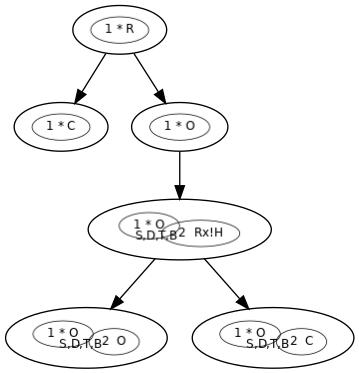

In [10]:
plot_tree(sidt, images=True)

In [12]:
train_error = [sidt.evaluate(d.mol, estimate_uncertainty=False) - d.value for d in train]
test_error = [sidt.evaluate(d.mol, estimate_uncertainty=False) - d.value for d in test]

In [13]:
np.mean(np.abs(np.array(train_error))) / 4184.0

20.309658550694007

In [14]:
np.mean(np.abs(np.array(test_error))) / 4184.0

22.33605598363266